1. Import and Install Dependencies

In [ ]:
!pip install tensorflow  opencv-python mediapipe scikit-learn matplotlib


In [5]:

import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import time
import mediapipe as mp

2. Keypoints using MP Holistic

C:\Users\laksh\AppData\Roaming\Python\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


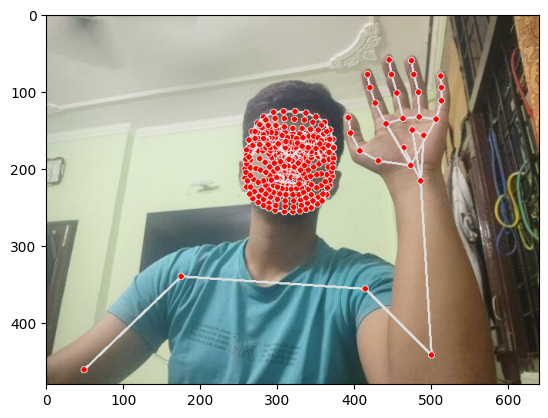

In [6]:
import cv2
import mediapipe as mp

# Initialize MediaPipe Holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion BGR to RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Color conversion RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245, 0, 0), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                             )

# Start video capture
cap = cv2.VideoCapture(0)

# Set up MediaPipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('Sign To Speech', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == 13:
            break

# Release resources
cap.release()
cv2.destroyAllWindows()

len(results.left_hand_landmarks.landmark)

results
draw_landmarks(frame, results)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

3. Extract Keypoint Values

In [7]:
len(results.left_hand_landmarks.landmark)


21

In [8]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [9]:
if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
else:
    face = np.zeros(1404)  # Adjust this size if needed

# Print the face array
print("Face landmarks array:")
print(face)

Face landmarks array:
[ 0.4925583   0.42500597 -0.0329621  ...  0.55593592  0.35122028
  0.02505516]


In [10]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

result_test = extract_keypoints(results)

result_test

array([ 0.49251074,  0.39368072, -0.5871371 , ...,  0.        ,
        0.        ,  0.        ])

In [7]:
np.save('0', result_test)
np.load('0.npy')

array([ 0.40878457,  0.36017802, -0.76349753, ...,  0.        ,
        0.        ,  0.        ])

4. Setup Folders for Collection

In [12]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou', 'bye' , 'good chat'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 10

for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

5. Collect Keypoint Values for Training and Testing

In [13]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == 13:
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

6. Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

label_map = {label:num for num, label in enumerate(actions)}

label_map

In [15]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(150, 10, 1662)

In [16]:
np.array(labels).shape

(150,)

In [17]:
X = np.array(sequences)
X.shape

(150, 10, 1662)

In [18]:
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(8, 5)

7. Build and Train LSTM Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])
model.summary()

C:\Users\laksh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - categorical_accuracy: 0.2111 - loss: 1.6131
Epoch 2/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.3283 - loss: 1.5814 
Epoch 3/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.2883 - loss: 1.5240 
Epoch 4/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.4172 - loss: 1.2954
Epoch 5/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3637 - loss: 1.3880
Epoch 6/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.4805 - loss: 1.2092 
Epoch 7/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.4624 - loss: 1.2317
Epoch 8/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.5703 - loss: 1.0599 
Epoch 9/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.5178 - loss: 1.0335 
Epoch 10/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.5424 - loss: 1.0219
Epoch 11/2000
5/5 ━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,225 (6.83 MB)

 Trainable params: 596,741 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,484 (4.55 MB)

8. Make Predictions

In [ ]:
res = model.predict(X_test)
actions[np.argmax(res[4])]

In [21]:
actions[np.argmax(y_test[4])]

'hello'

9. Save Weights

In [22]:
model.save('action.h5')

In [23]:
del model

In [1]:
from tensorflow.keras.models import load_model
model = load_model('action.h5')


10. Evaluation using Confusion Matrix and Accuracy

In [2]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [27]:

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

 11. Test in Real Time

In [3]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [15]:
import cv2
import numpy as np

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()

    # Print lengths for debugging
    print(f"Length of res: {len(res)}, actions: {len(actions)}, colors: {len(colors)}")

    # Ensure the lengths match
    min_length = min(len(res), len(actions), len(colors))

    for num in range(min_length):
        prob = res[num]  # Assuming res is a 1D array
        if isinstance(prob, (np.ndarray, list)):
            prob = prob.item()  # Use .item() for a single element array
        
        # Draw the rectangle with the probability scaled
        prob_scaled = int(prob * 100)
        prob_scaled = max(0, min(prob_scaled, 100))  # Ensure it's between 0 and 100
        
        # Draw the rectangle on the output frame
        cv2.rectangle(output_frame, (0, 60 + num * 40), (prob_scaled, 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (5, 85 + num * 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return output_frame


In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# Initialize variables
sequence = []
sentence = []
predictions = []
threshold = 0.5
frame_count = 0

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame for faster processing
        frame = cv2.resize(frame, (640, 480))
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            # print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

        # Display predictions on the frame
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
